# Decision Tree model

### In this notebook, we build, train, and tune by GridSearchCV a Decision Tree Classifier to predict the Outcome Type field of our review dataset.

## 1. Read the dataset and perform EDA
* Identify features and target
* Split features into numerical, categorical, and text
* Check distribution of numerical features, remove outliers
* Check unique values of categorical and text features, handle nan
* Preprocess text features (clean and apply stemming)

In [1]:
import pandas as pd
df = pd.read_csv('data/review_dataset.csv')
df.head()

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Age upon Outcome Days
0,A794011,1.0,Neutered Male,Chunk,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,Domestic Shorthair Mix,Brown Tabby/White,730,730
1,A776359,1.0,Neutered Male,Gizmo,7201 Levander Loop in Austin (TX),Stray,Normal,Dog,Intact Male,Chihuahua Shorthair Mix,White/Brown,365,365
2,A674754,0.0,Intact Male,NaN,12034 Research in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,Orange Tabby,6,6
3,A689724,1.0,Neutered Male,*Donatello,2300 Waterway Bnd in Austin (TX),Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Black,60,60
4,A680969,1.0,Neutered Male,*Zeus,4701 Staggerbrush Rd in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,White/Orange Tabby,7,60


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95485 entries, 0 to 95484
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pet ID                 95485 non-null  object 
 1   Outcome Type           95485 non-null  float64
 2   Sex upon Outcome       95484 non-null  object 
 3   Name                   59138 non-null  object 
 4   Found Location         95485 non-null  object 
 5   Intake Type            95485 non-null  object 
 6   Intake Condition       95485 non-null  object 
 7   Pet Type               95485 non-null  object 
 8   Sex upon Intake        95484 non-null  object 
 9   Breed                  95485 non-null  object 
 10  Color                  95485 non-null  object 
 11  Age upon Intake Days   95485 non-null  int64  
 12  Age upon Outcome Days  95485 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 9.5+ MB


In [3]:
df.describe()

,Outcome Type,Age upon Intake Days,Age upon Outcome Days
count,95485.000000,95485.000000,95485.000000
mean,0.564005,703.436959,717.757313
std,0.495889,1052.252197,1055.023160
min,0.000000,0.000000,0.000000
25%,0.000000,30.000000,60.000000
50%,1.000000,365.000000,365.000000
75%,1.000000,730.000000,730.000000
max,1.000000,9125.000000,9125.000000


In [4]:
#Separate target and features
target = 'Outcome Type'
features = df.drop(target, axis = 1).columns
features

Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color',
       'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')

In [5]:
##separate categorical features and numerical features 
import numpy as np
cat = df[features].select_dtypes(include = 'object').columns
num = df[features].select_dtypes(include = np.number).columns
print("Categorical features are", cat)
print("Numerical features are", num)

Categorical features are Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color'],
      dtype='object')
Numerical features are Index(['Age upon Intake Days', 'Age upon Outcome Days'], dtype='object')


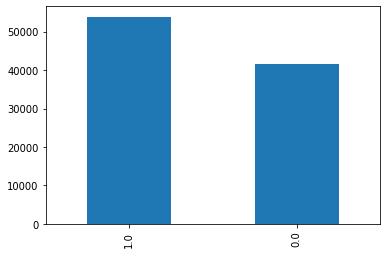

In [6]:
#check the distribution of target 
import matplotlib.pyplot as plt
df[target].value_counts().plot.bar()
plt.show()
%matplotlib inline

Age upon Intake Days


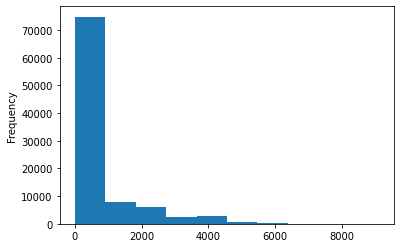

Age upon Outcome Days


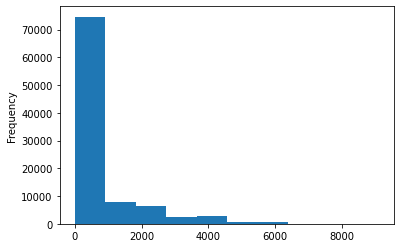

In [7]:
#check the distribution of numerical featuers
for n in num: 
    df[n].plot.hist(bins = 10)
    print(n)
    plt.show()

In [8]:
#remove outliers in numerical features
def IQR(df, col):
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    IQR = Q3 - Q1
    dropIndex = df[df[col] > Q3 + 1.5*IQR].index
    df.drop(dropIndex, inplace = True)
    dropIndex = df[df[col] < Q1 - 1.5*IQR].index
    df.drop(dropIndex, inplace = True)
    return df    

In [9]:
for n in num: 
    IQR(df, n)

In [10]:
df.shape

(82548, 13)

Age upon Intake Days


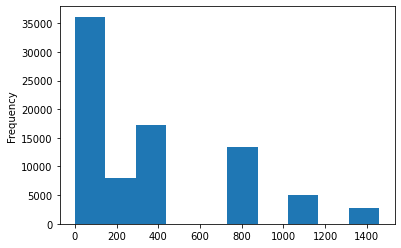

Age upon Outcome Days


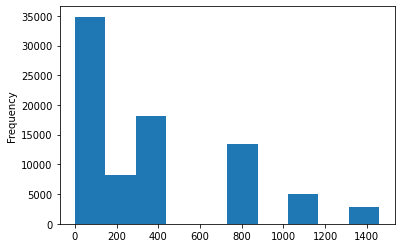

In [11]:
#replot numerical features distribution
for n in num:
    df[n].plot.hist(bins = 10)
    print(n)
    plt.show()

Sex upon Outcome


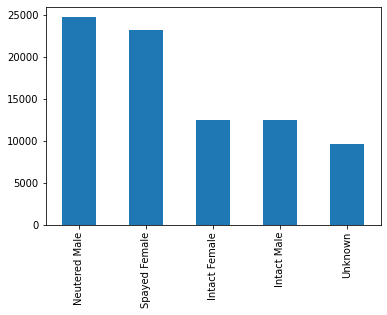

Intake Type


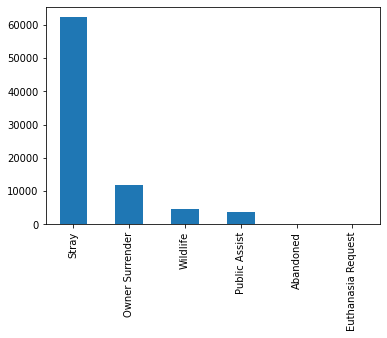

Intake Condition


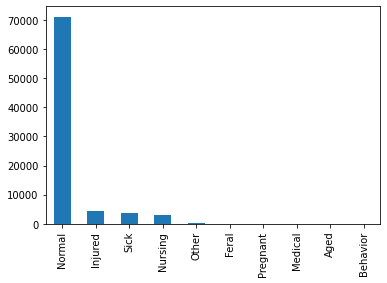

Pet Type


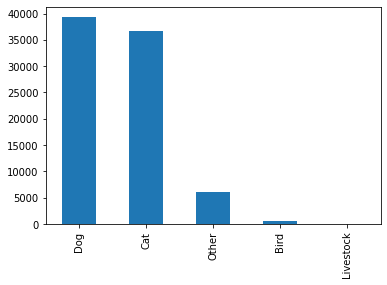

Sex upon Intake


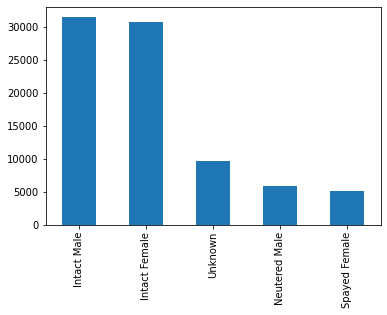

['Pet ID', 'Name', 'Found Location', 'Breed', 'Color']


In [12]:
#list out distinct values of categorical values
text_features = []
for c in cat: 
    if len(df[c].value_counts()) < 50:
        print(c)
        df[c].value_counts().plot.bar()
        plt.show()
    else: 
        text_features.append(c)
print(text_features)

In [13]:
cat = cat.drop(text_features)
print(cat)

Index(['Sex upon Outcome', 'Intake Type', 'Intake Condition', 'Pet Type',
       'Sex upon Intake'],
      dtype='object')


In [14]:
text_features.remove('Pet ID')

In [15]:
#check unique values in categorical features
for c in cat:
    print(c)
    print(df[c].unique())

Sex upon Outcome
['Neutered Male' 'Intact Male' 'Intact Female' 'Unknown' 'Spayed Female']
Intake Type
['Owner Surrender' 'Stray' 'Wildlife' 'Public Assist' 'Euthanasia Request'
 'Abandoned']
Intake Condition
['Normal' 'Nursing' 'Sick' 'Injured' 'Feral' 'Other' 'Pregnant' 'Aged'
 'Behavior' 'Medical']
Pet Type
['Cat' 'Dog' 'Other' 'Bird' 'Livestock']
Sex upon Intake
['Neutered Male' 'Intact Male' 'Intact Female' 'Unknown' 'Spayed Female']


In [16]:
for t in text_features: 
    print(t)
    print(df[t].unique())

Name
['Chunk' 'Gizmo' nan ... '*Lingonberry' 'Guawp' '*Squanchy']
Found Location
['Austin (TX)' '7201 Levander Loop in Austin (TX)'
 '12034 Research in Austin (TX)' ...
 '11025 Doyle Overton Road in Travis (TX)'
 '16010 Voelker Ln in Austin (TX)' '2211 Santa Rita Street in Austin (TX)']
Breed
['Domestic Shorthair Mix' 'Chihuahua Shorthair Mix' 'Domestic Shorthair'
 ... 'Angora-Satin' 'Unknown' 'Treeing Cur']
Color
['Brown Tabby/White' 'White/Brown' 'Orange Tabby' 'Black'
 'White/Orange Tabby' 'Brown Tabby' 'Gray' 'Calico' 'White/Tan' 'Brown'
 'Black/White' 'Brown/White' 'Black/Brown' 'Chocolate/White' 'White/White'
 'Brown Brindle/White' 'Gray/Black' 'Tortie' 'Tan' 'White/Blue Tabby'
 'Brown/Brown' 'Black/Gray' 'Blue' 'Cream Tabby' 'White' 'Brown/Black'
 'Brown/Gray' 'Blue Tabby/White' 'Red/White' 'Orange Tabby/White'
 'Brown Merle/White' 'Tricolor' 'Apricot' 'Black/Tan' 'Tortie Point'
 'Tan/Black' 'Torbie/Brown Tabby' 'White/Black' 'Blue Tabby' 'Blue Tick'
 'White/Gray' 'Black/Tricolo

In [17]:
#to avoid nan throwing errors when encoding text and categorical features , convert the features to string type
df[text_features] = df[text_features].astype(str)

In [18]:
#Prepare text pre-processing functions
import re
import string 
from nltk.stem import SnowballStemmer
stop_words = ['a','the','this','an','that','is','it','to','and']
stemmer = SnowballStemmer('english')

def preProcess(text):
    text = text.lower().strip()
    text = re.compile('<.*?>').sub('',text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub('',text)
    text = re.sub('\s+',' ', text)
    return text 

def lexicon(text, stop_words, stemmer):
    filtered_text = []
    words = text.split(' ')
    for w in words: 
        if w not in stop_words:
            filtered_text.append(stemmer.stem(w))
    text = ' '.join(filtered_text)
    return text

def cleanText(text, stop_words, stemmer):
    return lexicon(preProcess(text),stop_words, stemmer)
    

In [19]:
#Apply text cleaning function on text features
for t in text_features: 
    print('Text Cleaning',t)
    df[t] = [cleanText(item, stop_words, stemmer) for item in df[t].values]

Text Cleaning Name
Text Cleaning Found Location
Text Cleaning Breed
Text Cleaning Color


In [20]:
#Check text cleaning results 
for t in text_features: 
    print(t)
    print(df[t].nunique())

Name
11679
Found Location
37315
Breed
2159
Color
535


In [21]:
df.head()

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Age upon Outcome Days
0,A794011,1.0,Neutered Male,chunk,austin tx,Owner Surrender,Normal,Cat,Neutered Male,domest shorthair mix,brown tabbywhit,730,730
1,A776359,1.0,Neutered Male,gizmo,7201 levand loop in austin tx,Stray,Normal,Dog,Intact Male,chihuahua shorthair mix,whitebrown,365,365
2,A674754,0.0,Intact Male,nan,12034 research in austin tx,Stray,Nursing,Cat,Intact Male,domest shorthair mix,orang tabbi,6,6
3,A689724,1.0,Neutered Male,donatello,2300 waterway bnd in austin tx,Stray,Normal,Cat,Intact Male,domest shorthair mix,black,60,60
4,A680969,1.0,Neutered Male,zeus,4701 staggerbrush rd in austin tx,Stray,Nursing,Cat,Intact Male,domest shorthair mix,whiteorang tabbi,7,60


## 2. Train the Decision Tree model
* Split data into train and test dataset 
* Check for target imbalance in test set and apply target balancing 
* Use ColumnTransformer with Pipeline to process numerical, categorical, and text features  
* Combine data processing pipeline with decision tree classifier/estimator
* Train the model and evaluate performance of model on train and test dataset
* Perform hyperparameter tuning using gridsearch

In [22]:
#Divide dataset into training and testing 
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size = 0.1, shuffle = True, random_state = 23)

In [23]:
#Target balancing
print("trainining data set's size", train_data.shape)
print("Class 1 samples in the train dataset", sum(train_data[target] ==1))
print("Class 0 samples in the train dataset", sum(train_data[target]==0))

trainining data set's size (74293, 13)
Class 1 samples in the train dataset 40667
Class 0 samples in the train dataset 33626


In [24]:
#There are more class 1 samples than class 0 samples, use upsampling 
from sklearn.utils import shuffle
class0 = train_data[train_data[target] ==0]
class1 = train_data[train_data[target]==1]
upsampled_class0 = class0.sample(n = len(class1), replace = True, random_state = 42)
train_data = pd.concat([upsampled_class0, class1])
train_data = shuffle(train_data)

In [25]:
print("trainining data set's size", train_data.shape)
print("Class 1 samples in the train dataset", sum(train_data[target] ==1))
print("Class 0 samples in the train dataset", sum(train_data[target]==0))

trainining data set's size (81334, 13)
Class 1 samples in the train dataset 40667
Class 0 samples in the train dataset 40667


In [26]:
#Numerical pipeline. Impute and scale 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

numerical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy = 'mean')),
    ('scal', MinMaxScaler())
        ])

In [27]:
#Categorical pipeline. Impute and One hote encoding
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy = 'constant', fill_value='missing')),
        ('scale', OneHotEncoder(handle_unknown = 'ignore'))
        ])

In [28]:
#Text pipeline. CountVectorizer using Bag of Words. Use two separate pipelines to handle different vocabulary size 
from sklearn.feature_extraction.text import CountVectorizer

text_pipeline_1 = Pipeline([
    ('vectorized', CountVectorizer(binary= True, max_features=50))
        ])

text_pipeline_2 = Pipeline([
    ('vectorized', CountVectorizer(binary = True, max_features = 150))
    ])

In [29]:
text_features

['Name', 'Found Location', 'Breed', 'Color']

In [30]:
#Combine all pipelines using ColumnTransformer. Note features to be processed has to be list object
from sklearn.compose import ColumnTransformer
data_processer = ColumnTransformer([
        ('num_pipe', numerical_pipeline, num.tolist()),
        ('cat_pipe', categorical_pipeline, cat.tolist()),
        ('text_pipe1', text_pipeline_1, text_features[3]),
        ('text_pipe2', text_pipeline_2, text_features[2])
        ])

In [31]:
#combine data preprocessing with decision tree classifier in a pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
    ('data_preprocess', data_processer),
    ('decisiontree', DecisionTreeClassifier())
     ])

from sklearn import set_config
set_config(display = 'diagram')
pipeline

Pipeline(steps=[('data_preprocess',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scal',
                                                                   MinMaxScaler())]),
                                                  ['Age upon Intake Days',
                                                   'Age upon Outcome Days']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('scale',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex upon Outcome',
                                                   'Intake Type',
                                                   'Intake Condition',
                                                   'Pet Type',
                                                   'Sex upon Intake']),
                                                 ('text_pipe1',
                                                  Pipeline(steps=[('vectorized',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'Color'),
                                                 ('text_pipe2',
                                                  Pipeline(steps=[('vectorized',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'Breed')])),
                ('decisiontree', DecisionTreeClassifier())])

In [32]:
model_features = num.tolist()+cat.tolist()+text_features[2:]
print(model_features)

['Age upon Intake Days', 'Age upon Outcome Days', 'Sex upon Outcome', 'Intake Type', 'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color']


In [33]:
#Train the model
X_train = train_data[model_features]
y_train = train_data[target]

pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocess',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scal',
                                                                   MinMaxScaler())]),
                                                  ['Age upon Intake Days',
                                                   'Age upon Outcome Days']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('scale',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex upon Outcome',
                                                   'Intake Type',
                                                   'Intake Condition',
                                                   'Pet Type',
                                                   'Sex upon Intake']),
                                                 ('text_pipe1',
                                                  Pipeline(steps=[('vectorized',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'Color'),
                                                 ('text_pipe2',
                                                  Pipeline(steps=[('vectorized',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'Breed')])),
                ('decisiontree', DecisionTreeClassifier())])

In [34]:
#Use the fitted model on train data 
train_predictions = pipeline.predict(X_train)

In [35]:
#Evaluate performance of model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print("Confusion Matrix")
print(confusion_matrix(y_train, train_predictions))
print("Accuracy Score is", accuracy_score(y_train, train_predictions))
print(classification_report(y_train, train_predictions))

Confusion Matrix
[[38952  1715]
 [ 2386 38281]]
Accuracy Score is 0.9495782821452283
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     40667
         1.0       0.96      0.94      0.95     40667

    accuracy                           0.95     81334
   macro avg       0.95      0.95      0.95     81334
weighted avg       0.95      0.95      0.95     81334



In [36]:
#Use the fitted model on test data
X_test = test_data[model_features]
y_test = test_data[target]
pipeline.fit(X_test, y_test)
test_prediction = pipeline.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test, test_prediction))
print("Accuracy Score is", accuracy_score(y_test, test_prediction))
print(classification_report(y_test, test_prediction))

Confusion Matrix
[[3616   50]
 [ 134 4455]]
Accuracy Score is 0.9777104784978801
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      3666
         1.0       0.99      0.97      0.98      4589

    accuracy                           0.98      8255
   macro avg       0.98      0.98      0.98      8255
weighted avg       0.98      0.98      0.98      8255



## !Important. The name of the classifier used in paramgrid (prefix of the hyperparameters) has to match the name of the classifier specified in the pipeline

In [39]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Parameter grid for GridSearch
param_grid={'decisiontree__max_depth': [100, 200, 300],#, 50, 75, 100, 125, 150, 200, 250], 
            'decisiontree__min_samples_leaf': [5, 10, 15],#, 25, 30],
            'decisiontree__min_samples_split': [2, 5, 15]#, 25, 30, 45, 50]
           }

gridsearch = GridSearchCV(pipeline, 
             param_grid, 
             cv = 5, 
             verbose = 1,
             n_jobs= -1)
            
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_preprocess',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scal',
                                                                                          MinMaxScaler())]),
                                                                         ['Age '
                                                                          'upon '
                                                                          'Intake '
                                                                          'Days',
                                                                          'Age '
                                                                          'upon '
                                                                          'Outcome '
                                                                          'Days']),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('scale',
                                                                                          OneHotEncoder(...
                                                                                          CountVectorizer(binary=True,
                                                                                                          max_features=50))]),
                                                                         'Color'),
                                                                        ('text_pipe2',
                                                                         Pipeline(steps=[('vectorized',
                                                                                          CountVectorizer(binary=True,
                                                                                                          max_features=150))]),
                                                                         'Breed')])),
                                       ('decisiontree',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontree__max_depth': [100, 200, 300],
                         'decisiontree__min_samples_leaf': [5, 10, 15],
                         'decisiontree__min_samples_split': [2, 5, 15]},
             verbose=1)

In [40]:
print(gridsearch.best_params_)
print(gridsearch.best_score_)

{'decisiontree__max_depth': 100, 'decisiontree__min_samples_leaf': 10, 'decisiontree__min_samples_split': 15}
0.8385300297897548


## 3. Retrain the decision model using the tuned parameters

In [41]:
classifier = gridsearch.best_estimator_

classifier.fit(X_train, y_train)

Pipeline(steps=[('data_preprocess',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scal',
                                                                   MinMaxScaler())]),
                                                  ['Age upon Intake Days',
                                                   'Age upon Outcome Days']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('scale',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex upon Out...
                                                   'Intake Type',
                                                   'Intake Condition',
                                                   'Pet Type',
                                                   'Sex upon Intake']),
                                                 ('text_pipe1',
                                                  Pipeline(steps=[('vectorized',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'Color'),
                                                 ('text_pipe2',
                                                  Pipeline(steps=[('vectorized',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'Breed')])),
                ('decisiontree',
                 DecisionTreeClassifier(max_depth=100, min_samples_leaf=10,
                                        min_samples_split=15))])

In [42]:
train_pred = classifier.predict(X_train)
print(confusion_matrix(y_train, train_pred))
print("Accuracy Score is", accuracy_score(y_train, train_pred))
print(classification_report(y_train, train_pred))
      

[[34114  6553]
 [ 4404 36263]]
Accuracy Score is 0.8652838911156466
              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86     40667
         1.0       0.85      0.89      0.87     40667

    accuracy                           0.87     81334
   macro avg       0.87      0.87      0.87     81334
weighted avg       0.87      0.87      0.87     81334



In [43]:
test_prediction = classifier.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(y_test, test_prediction))
print("Accuracy Score is", accuracy_score(y_test, test_prediction))
print(classification_report(y_test, test_prediction))

Confusion Matrix
[[2845  821]
 [ 633 3956]]
Accuracy Score is 0.8238643246517262
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80      3666
         1.0       0.83      0.86      0.84      4589

    accuracy                           0.82      8255
   macro avg       0.82      0.82      0.82      8255
weighted avg       0.82      0.82      0.82      8255



### In this case the tuned parameters performed worse than the original model, could be the gridsearch is not exhaustive enough or the parameters chosen in the paragrid are worse than the original